In [6]:

def my_function(table):
    from matplotlib import pyplot
    from pandas import DataFrame
    from sklearn.preprocessing import MinMaxScaler
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.callbacks import EarlyStopping
    import tensorflow.keras as keras
    import tensorflow_addons as tfa
    from tensorflow.keras.layers import RNN

    Moggio = table.dropna(how="any")
    Moggio = Moggio.reset_index()

    values = Moggio.iloc[:,3:].values
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    n_days = 5
    reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
    # drop columns we don't want to predict (we therefore keep Ammonia)
    reframed.drop(reframed.columns[[36,37,38,39,40,41]], axis=1, inplace=True)

    # split into train and test sets
    values = reframed.values
    n_features = 7 # number of variables, including the one to be predicted
    n_train_days = 1667-365 # we train using only the first year
    train = values[:n_train_days, :]
    test = values[n_train_days:, :] # we test using all successive years 
    # split into input and outputs
    n_obs = n_days * n_features
    train_X, train_y = train[:, :n_obs], train[:, -1]
    test_X, test_y = test[:, :n_obs], test[:, -1]
    print(train_X.shape, len(train_X), train_y.shape)
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

    # design network
    model = Sequential()
    model.add(RNN(tfa.rnn.LayerNormLSTMCell(50), return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(RNN(tfa.rnn.LayerNormLSTMCell(50), return_sequences=True))
    model.add(RNN(tfa.rnn.LayerNormLSTMCell(50), return_sequences=False))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    early_stopping = EarlyStopping(patience=10, restore_best_weights = True)
    history = model.fit(train_X, train_y, epochs=1000, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=early_stopping)
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()






(1302, 35) 1302 (1302,)
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-02-18 22:00:44.312052: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-18 22:00:44.312527: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-02-18 22:00:44.880528: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-18 22:00:44.883292: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/1000


2022-02-18 22:00:46.536352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-18 22:00:56.657253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


27/27 - 12s - loss: 0.0734 - val_loss: 0.0477
Epoch 2/1000
27/27 - 7s - loss: 0.0164 - val_loss: 0.0477
Epoch 3/1000
27/27 - 7s - loss: 0.0164 - val_loss: 0.0469
Epoch 4/1000
27/27 - 7s - loss: 0.0161 - val_loss: 0.0509
Epoch 5/1000
27/27 - 7s - loss: 0.0177 - val_loss: 0.0552
Epoch 6/1000
27/27 - 7s - loss: 0.0204 - val_loss: 0.0588
Epoch 7/1000
27/27 - 7s - loss: 0.0251 - val_loss: 0.0547
Epoch 8/1000
27/27 - 7s - loss: 0.0296 - val_loss: 0.0391
Epoch 9/1000
27/27 - 7s - loss: 0.0267 - val_loss: 0.0257
Epoch 10/1000
27/27 - 8s - loss: 0.0163 - val_loss: 0.0203
Epoch 11/1000
27/27 - 7s - loss: 0.0095 - val_loss: 0.0183
Epoch 12/1000
27/27 - 7s - loss: 0.0072 - val_loss: 0.0174
Epoch 13/1000
27/27 - 7s - loss: 0.0063 - val_loss: 0.0172
Epoch 14/1000
27/27 - 7s - loss: 0.0059 - val_loss: 0.0167
Epoch 15/1000
27/27 - 7s - loss: 0.0055 - val_loss: 0.0161
Epoch 16/1000
27/27 - 7s - loss: 0.0052 - val_loss: 0.0154
Epoch 17/1000
27/27 - 7s - loss: 0.0049 - val_loss: 0.0148
Epoch 18/1000
27/2

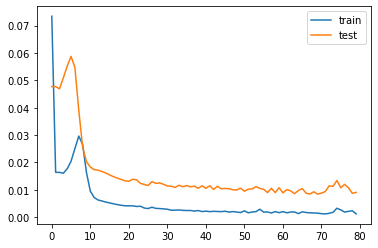

In [11]:
from pandas import read_csv

table = read_csv('/Users/davidguzman/Downloads/Quadranti.csv')
my_function(table)

In [5]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg